## Implementing a student financial aid finder with Agentic Workflows
<link rel="stylesheet"
href="https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css"
integrity="sha384-JcKb8q3iqJ61gNV9KGb8thSsNjpSL0n8PARn9HuZOnIxN0hoP+VmmDGMN5t9UJ0Z"
crossorigin="anonymous">
<div class="bg-info">
<h3>What are agentic workflows?</h3>
</div>

An <b>agentic workflow</b> is a multi-step sequence of tasks or decisions whose orchestration is handled by AI agents. In Generative AI, AI agents are Large Language Models (or "Large Action Models" in this context) that can perform goal-oriented tasks with minimal human intervention. Such tasks may include everything from simple reasoning tasks to complex decision making, and often involve interaction with external resources or systems (called "tools").

The following will build an agentic workflow for finding scholarships and other student aid. The initial version of the workflow will consist of the following steps:


1.   A **screener** agent (LLM) builds a list of relevant questions for the interviewer to use to converse with the user.
2.   An **interviewer** agent (LLM) handles back-and-forth interaction with the user to gather enough information for the co-interviewer agent. During each turn, it will narrow down relevant questions for the interview and iteratively feed them to the user. Once it thinks it has a complete user profile, it will end the interview and the reporter will be notified.
3.   A **reporter** agent (LLM + tool) receives notification from the interviewer agent that the interview has ended, then generates a personalized report containing student aid options that match the user's profile.



<div class="bg-info">
<h3>What is the difference between an agentic framework and an agentic orchestration framework?</h3>
</div>

There are different schools of thought about agentic orchestration frameworks.

Agentic orchestration can refer to <b>agent-of-agent</b> systems, which are defined based on the number of agents. In this case, they are simply agentic systems that consist of more than a single agent. Hence, it can refer to agentic systems with multiple agents; it can also refer to agentic systems that invoke other agentic systems.

Sometimes, agentic orchestration can also be used to distinguish complex multi-agent systems from simpler agentic systems. In this case, agentic orchestration is only necessary for systems with high levels of complexity. This is based on not just the number of agents, but other factors such as the types of flows (directed versus cyclic).

There are many frameworks that can be used for building agentic workflows. Due to their reasoning and decision-making abilities, LLMs are a natural fit for driving autonomous workflows. However, users often want the ability to extend, constrain or even override aspects of the flow. For example, they may need a way to dynamically limit cycles, manage state across disparate tools, or integrate human-in-the-loop fedback. A popular approach is to use <b>LLM orchestration</b> frameworks. These are frameworks that combine the flexible and dynamic capabilities of agent-driven workflows with low-level control over essential details of the orchestration. This notebook uses <b>LangChain</b> to build the AI agents, and <b>LangGraph</b> to build the agentic workflow that orchestrates the agents.

<div class="bg-info">
<h3>Workflow Summary</h3>
</div>

Steps of the Scholarship Finder:
- <i>Screener</i> builds a list of questions that will be used by the interviewer for the conversation with the user.
- <i>Interviewer</i> agent receives the user's student aid inquiry and uses it to initiate an interview with the user.
  - The interviewer extracts the latest user profile and uses it to analyze whether there is enough information to answer the interview questions.
      - If there is not enough information, the interviewer selects one of the questions to prompt to the user using an interrupt.
      - Else (i.e. there is enough information), the workflow redirects to the reporter agent.
- <i>Reporter</i> agent generates a personalized report of student aid that the user could qualify for.
  - The reporter uses its RAG tool to include a reference to a document in the data store for each student aid option.
  - The workflow ends.

# Setup

In [1]:
# Import libraries
from typing import TypedDict, Literal
import json
import random
from langgraph.graph import END, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod
from langchain_core.messages import HumanMessage
import os
from typing import Annotated, Literal, TypedDict
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import filter_messages
from langchain_openai import ChatOpenAI
import functools
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from langchain.text_splitter import RecursiveCharacterTextSplitter
import time
from ipywidgets import FileUpload, Button
from IPython.display import display
import codecs
import re
from vectordb_processor import VectorDbProcessor
import traceback

## Defining Templates
Each agent has its own specific **template**. The templates are defined here.

In [2]:
screener_template = """
Can you ask me some short questions that could be used to find out how to qualify for college financial aid in this state, including scholarships, grants, etc?
Use intuitive, simple language.

Start with these lines: 
FROM SCREENER
*START QUESTIONS

End with this line:
*END QUESTIONS
"""

interviewer_template = """
You are a friendly interviewer. Please analyze the following questions to the best of your ability. 

For each question, if more information is needed to provide a definitive answer about college financial aid eligibility, say NOT_ENOUGH_INFO next to the question, 
but if no more information is needed to provide a definitive answer about college financial aid eligibility, 
say HAS_ENOUGH_INFO next to the question. Explain your answer. Try to use one sentence in your answers.

Start with this line: 
FROM INTERVIEWER
"""

reporter_template = """
You are an intelligent analyst. Given the information below, what student aid am I likely to qualify for in this state? 

Where possible, for each student aid type in your answer, try to include the names of specific programs, institutions or organizations. 

If I am highly likely to qualify, say so, otherwise say that I am not likely to qualify. 

Start with this line: 
FROM REPORTER

When you're finished, say FINISHED.
"""

reporter_tool_prompt_template = """
Given this information, what student aid am I likely to qualify for in this state? 
"""

## Defining State
Here, we will define our **GraphState**, as well as the **nodes** and **edges** that our graph is comprised of. This will encapsulate **state** in our agentic workflows.

In [3]:
#####################################
## STATE ##
#####################################
class NMAgentState(TypedDict):
  """
  Encapsulates state in our agentic workflow
  """
  messages: Annotated[list, add_messages]
  userinfo: Annotated[list, add_messages]
  questions: str

#####################################
## TOOLS ##
#####################################
@tool
def reporter_tool(reporter_tool_prompt_template):
    """
    Agentic RAG tool for Reporter
    """
    prompt = ChatPromptTemplate.from_messages([("system","{system_message}",), MessagesPlaceholder(variable_name="userinfo"), MessagesPlaceholder(variable_name="questions"),])
    prompt = prompt.partial(system_message=system_prompt)
    return prompt | granite_llm
    
#####################################
## AGENTS ##
#####################################
"""
The LLMs used by the agents
"""
granite_llm = ChatOpenAI(temperature=0,
                         model="granite-3-3-8b-instruct",
                         request_timeout=240,
                         api_key=os.getenv('GRANITE_API_KEY'),
                         base_url=os.getenv('GRANITE_API_BASE'),
                        )

def create_agent(llm, tools, system_message: str, messages_key: str = None):
    """
    Creates an agent with the given LLM, tools, and system message
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name=messages_key or "messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    if tools:
      return prompt | llm.bind_tools(tools)
    else:
      return prompt | llm

screener_agent = create_agent(granite_llm, [], screener_template)
interviewer_agent = create_agent(granite_llm, [], interviewer_template)
reporter_agent = create_agent(granite_llm, [], reporter_template)

#####################################
## NODES ##
#####################################
def agent_node(state, agent, name):
  print(f"here: {name}")
  output = agent.invoke(state)

  incomplete_question = find_incomplete_question(output.content)

    
  if (incomplete_question):
      incomplete_question_response = interrupt(value=f"### Question: {incomplete_question}")
      
      results = [output] + [HumanMessage(content=incomplete_question_response)]
  else:
      results = [output]
      
  return { "messages": results, 
          "questions": parse_questions(output.content) or state['questions'],
          "userinfo": filter_messages(state['messages']+[output],include_types="human")}

screener_node = functools.partial(agent_node, agent=screener_agent, name="Screener Agent")
interviewer_node = functools.partial(agent_node, agent=interviewer_agent, name="Interviewer Agent")
reporter_node = functools.partial(agent_node, agent=reporter_agent, name="Reporter Agent")
reporter_tool_node = ToolNode([reporter_tool])

#####################################
## CONDITIONAL EDGES ##
#####################################
def should_continue_interview(state) -> Literal['interviewer','reporter']:
    if len(state['messages']) and state['questions'] and find_incomplete_question(state['messages'][-1].content) is None:
        return "reporter"
    else:
        return "interviewer"
    
def should_generate_report(state) -> Literal['reporter-tools', END]:
  if len(state['messages']) and 'tool_calls' in state['messages'][-1] and state['messages'][-1].tool_calls:
      return "reporter-tools"
  else:
      return END


#####################################
## UTILITY METHODS ##
#####################################
def parse_questions(content: str) -> bool:
    if content is None:
        return ""
    pattern = r"\*START QUESTIONS(.*?)\*END QUESTIONS"
    match = re.search(pattern, content, re.DOTALL)
    return match.group(1).strip() if match else ""

def find_incomplete_question(content: str) -> str:
    if content is None:
        return None 
    pattern = r"(.*(\n){1})NOT_ENOUGH_INFO"
    match = re.search(pattern, content)
    return match.group(1).strip() if match else None
    

## Defining the Workflow Graph
Here, we will define the workflow, which will encapsulate the state, nodes and edges defined above.

In [4]:
workflow = StateGraph(NMAgentState)

# nodes
workflow.add_node("screener", screener_node)
workflow.add_node("interviewer", interviewer_node)
workflow.add_node("reporter", reporter_node)
workflow.add_node("reporter-tools", reporter_tool_node)

# entrypoint
workflow.set_entry_point("screener")

# edges
workflow.add_edge("screener", "interviewer")
workflow.add_conditional_edges("interviewer", should_continue_interview)
# workflow.add_conditional_edges("reporter", should_generate_report)
workflow.add_edge("reporter", END)
workflow.add_edge("reporter-tools", "reporter")

# compile the workflow into a graph
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

Visualize the graph:

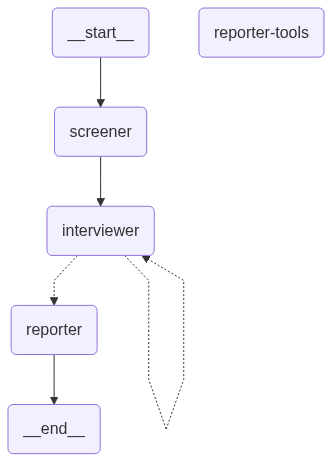

In [5]:
Image(graph.get_graph().draw_mermaid_png())

# Testing the workflow
Now that the workflow has been generated, we can test it out with different prompts.

In [6]:
# Prompt to test
input_text = f"""I live in California."""

In [7]:
def run_stream(stream):
    try:
      for event in stream:
          if '__interrupt__' in event:
              input_text = input(event['__interrupt__'][0].value)
              stream = graph.stream(Command(resume=input_text), config=config, stream_mode="values")
              run_stream(stream)
              continue
          else:
              last_message = event['messages'][-1]
              last_message.pretty_print()
    except Exception as e:
      print(f"\n\nErrors generating response:\n===============\n {str(e)}")
      traceback.print_exc()

config = {"configurable": {"thread_id": 13, "recursion_limit": 5}}
stream = graph.stream({"messages": [HumanMessage(content=input_text)],"questions":None, "userinfo":[]}, config, stream_mode="values")
run_stream(stream)

================================ Human Message =================================

I live in California.
here: Screener Agent
================================== Ai Message ==================================

FROM SCREENER
*START QUESTIONS

1. Are you a resident of California?
2. Have you applied or been accepted to a college or university in California?
3. Do you plan to enroll as a full-time or part-time student?
4. Have you or your parents saved for college using a 529 plan?
5. Are you a low-income student or come from a low-income family?
6. Are you a first-generation college student, meaning neither of your parents has a bachelor's degree?
7. Do you belong to a racial or ethnic minority group underrepresented in higher education?
8. Have you demonstrated exceptional academic or artistic talent?
9. Are you a veteran or dependent of a veteran?
10. Do you have any special skills or talents that could qualify you for specific scholarships?
11. Have you explored the California State Univ

### Question: 2. Have you applied or been accepted to a college or university in California? I applied to Berkley but was not accepted.


================================== Ai Message ==================================

FROM SCREENER
*START QUESTIONS

1. Are you a resident of California?
2. Have you applied or been accepted to a college or university in California?
3. Do you plan to enroll as a full-time or part-time student?
4. Have you or your parents saved for college using a 529 plan?
5. Are you a low-income student or come from a low-income family?
6. Are you a first-generation college student, meaning neither of your parents has a bachelor's degree?
7. Do you belong to a racial or ethnic minority group underrepresented in higher education?
8. Have you demonstrated exceptional academic or artistic talent?
9. Are you a veteran or dependent of a veteran?
10. Do you have any special skills or talents that could qualify you for specific scholarships?
11. Have you explored the California State University (CSU) and University of California (UC) systems' specific financial aid resources?
12. Are you aware of any private sc